## Imports

In [1]:
import xarray as xr

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Open the data

In [3]:
# data in persistent bucket
target_url = 'gs://leap-persistent/tomnicholas/hero-calc/compute/llc4320/vort_strain_div_histogram_coarsen_nan_padding_3_hourly.zarr'

In [4]:
hist_ds = xr.open_dataset(target_url, engine="zarr", chunks={})

In [5]:
hist_ds['histogram_vort_strain_div'].isel(time=0).nbytes / 1e9

1.682792496

In [6]:
from xarray.indexes import PandasIndex

# have to add the index ourselves manually for some reason
hist_ds = hist_ds.set_xindex('region_num', PandasIndex)

## Correct PDF normalization

Division by 80 comes from 8 samples per day (3-hourly sampling of hourly data) over a 10-day period. 
This correction is currently required because I accidentally did `coarsen(time=8*10).sum(dim='time')` instead of `coarsen(time=8*10).mean(dim='time')` before saving to zarr.

In [7]:
hist_ds['histogram_vort_strain_div'] = hist_ds['histogram_vort_strain_div'] / 80

## Expectation values

In [8]:
def marginalize(pdf: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Integrate out one or more dimensions of the PDF to remove dependence on that quantity,
    whilst still preserving the total integrated probability.
    """
       
    all_bin_dims = ['vort_bin', 'strain_bin', 'div_bin']
    
    if isinstance(dims, str):
        dims = [dims]
    
    if dims is None:
        dims=all_bin_dims
    
    if any(d not in all_bin_dims for d in dims):
        raise ValueError("Can't take marginal PDF over a dimension which is not a variable of the original PDF")
    
    marginal_pdf = pdf

    # TODO these might be more accurate if we used xarray's integrate function
    if 'vort_bin' in dims:
        vort_bin_width = pdf['vort_bin'].diff('vort_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='vort_bin') * vort_bin_width
        
    if 'strain_bin' in dims:
        strain_bin_width = pdf['strain_bin'].diff('strain_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='strain_bin') * strain_bin_width
        
    if 'div_bin' in dims:
        div_bin_width = pdf['div_bin'].diff('div_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='div_bin') * div_bin_width
        
    return marginal_pdf


def expectation(pdf: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Take the expectation value of x over the given Probability Density Function.
    """
    
    return marginalize(pdf * x, dims=dims)

In [9]:
@xr.register_dataarray_accessor("pdf")
class DataArrayPDFAccessor:
    def __init__(self, da: xr.DataArray):
        self._da = da
        
    def marginalize(self, dims: str | list = None) -> xr.DataArray:
        return marginalize(self._da, dims=dims)
    
    def expectation(self, x, dims: str | list = None) -> xr.DataArray:
        return expectation(self._da, x, dims=dims)

## Latitude-dependent mean

We want to find the mean of all histograms, but defining the mean in such a way that it varies with latitude but not longitude, i.e. not across all regions.

In [10]:
hist_ds

<xarray.Dataset>
Dimensions:                    (div_bin: 99, region: 438, time: 37,
                                vort_bin: 99, strain_bin: 49, vertices: 4)
Coordinates:
  * div_bin                    (div_bin) float64 -4.949 -4.848 ... 4.848 4.949
    face                       (region) int64 dask.array<chunksize=(13,), meta=np.ndarray>
    i_region_coarse            (region) int64 dask.array<chunksize=(438,), meta=np.ndarray>
    j_region_coarse            (region) int64 dask.array<chunksize=(438,), meta=np.ndarray>
  * region_num                 (region) int64 4 5 6 7 13 ... 791 792 793 798 799
  * strain_bin                 (strain_bin) float64 0.05102 0.1531 ... 4.949
  * time                       (time) datetime64[ns] 2011-09-17T22:30:00 ... ...
    vertices_latitude          (vertices, region) float32 dask.array<chunksize=(4, 438), meta=np.ndarray>
    vertices_longitude         (vertices, region) float32 dask.array<chunksize=(4, 438), meta=np.ndarray>
  * vort_bin                   (vort_bin) float64 -4.949 -4.848 ... 4.848 4.949
Dimensions without coordinates: region, vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 dask.array<chunksize=(1, 1, 99, 49, 99), meta=np.ndarray>

In [11]:
# find the latitude of the centrepoint of each region polygon
lat = hist_ds['vertices_latitude'].mean(dim='vertices').rename('center_latitude')
lat

<xarray.DataArray 'center_latitude' (region: 438)>
dask.array<mean_agg-aggregate, shape=(438,), dtype=float32, chunksize=(438,), chunktype=numpy.ndarray>
Coordinates:
    face             (region) int64 dask.array<chunksize=(13,), meta=np.ndarray>
    i_region_coarse  (region) int64 dask.array<chunksize=(438,), meta=np.ndarray>
    j_region_coarse  (region) int64 dask.array<chunksize=(438,), meta=np.ndarray>
  * region_num       (region) int64 4 5 6 7 13 14 15 ... 790 791 792 793 798 799
Dimensions without coordinates: region

In [12]:
hist_ds.coords['lat'] = lat.load()
hist_ds

<xarray.Dataset>
Dimensions:                    (div_bin: 99, region: 438, time: 37,
                                vort_bin: 99, strain_bin: 49, vertices: 4)
Coordinates:
  * div_bin                    (div_bin) float64 -4.949 -4.848 ... 4.848 4.949
    face                       (region) int64 0 0 0 0 0 0 ... 12 12 12 12 12 12
    i_region_coarse            (region) int64 0 0 0 0 1 1 1 2 ... 2 2 2 3 3 3 3
    j_region_coarse            (region) int64 4 5 6 7 5 6 7 5 ... 4 6 7 0 1 6 7
  * region_num                 (region) int64 4 5 6 7 13 ... 791 792 793 798 799
  * strain_bin                 (strain_bin) float64 0.05102 0.1531 ... 4.949
  * time                       (time) datetime64[ns] 2011-09-17T22:30:00 ... ...
    vertices_latitude          (vertices, region) float32 dask.array<chunksize=(4, 438), meta=np.ndarray>
    vertices_longitude         (vertices, region) float32 dask.array<chunksize=(4, 438), meta=np.ndarray>
  * vort_bin                   (vort_bin) float64 -4.949 -4.848 ... 4.848 4.949
    lat                        (region) float32 -73.97 -69.45 ... -73.68 -73.86
Dimensions without coordinates: region, vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 dask.array<chunksize=(1, 1, 99, 49, 99), meta=np.ndarray>

In [13]:
lat_bin_edges = np.arange(start=-90, stop=91, step=10)
lat_bin_edges

array([-90, -80, -70, -60, -50, -40, -30, -20, -10,   0,  10,  20,  30,
        40,  50,  60,  70,  80,  90])

In [14]:
h_vs_lat = hist_ds['histogram_vort_strain_div'].groupby_bins('lat', lat_bin_edges).mean(dim='region').isel(time=0)
h_vs_lat

<xarray.DataArray 'histogram_vort_strain_div' (vort_bin: 99, strain_bin: 49,
                                               div_bin: 99, lat_bins: 18)>
dask.array<getitem, shape=(99, 49, 99, 18), dtype=float64, chunksize=(99, 49, 99, 1), chunktype=numpy.ndarray>
Coordinates:
  * div_bin     (div_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949
  * strain_bin  (strain_bin) float64 0.05102 0.1531 0.2551 ... 4.745 4.847 4.949
    time        datetime64[ns] 2011-09-17T22:30:00
  * vort_bin    (vort_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949
  * lat_bins    (lat_bins) object (-90, -80] (-80, -70] ... (70, 80] (80, 90]

In [15]:
h_vs_lat.pdf.expectation(1).load()

<xarray.DataArray (lat_bins: 18)>
array([0.        , 1.0017813 , 1.00757282, 1.01151839, 1.0047085 ,
       1.00905651, 1.01497235, 1.02412999, 1.01651403, 1.01582547,
       1.01898524, 1.00710788, 1.01646905, 1.02777282, 1.01558758,
       1.01121717, 1.00704632, 1.01325677])
Coordinates:
    time        datetime64[ns] 2011-09-17T22:30:00
  * lat_bins    (lat_bins) object (-90, -80] (-80, -70] ... (70, 80] (80, 90]
    vort_bin    float64 -4.848
    strain_bin  float64 0.1531
    div_bin     float64 -4.848

In [16]:
h_vort_strain_vs_lat = h_vs_lat.pdf.marginalize('div_bin')
h_vort_strain_vs_lat

<xarray.DataArray (vort_bin: 99, strain_bin: 49, lat_bins: 18)>
dask.array<mul, shape=(99, 49, 18), dtype=float64, chunksize=(99, 49, 1), chunktype=numpy.ndarray>
Coordinates:
  * strain_bin  (strain_bin) float64 0.05102 0.1531 0.2551 ... 4.745 4.847 4.949
    time        datetime64[ns] 2011-09-17T22:30:00
  * vort_bin    (vort_bin) float64 -4.949 -4.848 -4.747 ... 4.747 4.848 4.949
  * lat_bins    (lat_bins) object (-90, -80] (-80, -70] ... (70, 80] (80, 90]
    div_bin     float64 -4.848

In [17]:
h_vort_strain_vs_lat.pdf.expectation(1, dims=['vort_bin', 'strain_bin']).load()

<xarray.DataArray (lat_bins: 18)>
array([0.        , 1.0017813 , 1.00757282, 1.01151839, 1.0047085 ,
       1.00905651, 1.01497235, 1.02412999, 1.01651403, 1.01582547,
       1.01898524, 1.00710788, 1.01646905, 1.02777282, 1.01558758,
       1.01121717, 1.00704632, 1.01325677])
Coordinates:
    time        datetime64[ns] 2011-09-17T22:30:00
  * lat_bins    (lat_bins) object (-90, -80] (-80, -70] ... (70, 80] (80, 90]
    div_bin     float64 -4.848
    vort_bin    float64 -4.848
    strain_bin  float64 0.1531

In [41]:
h_vort_strain_vs_lat.sum(dim=['vort_bin', 'strain_bin']).load()

<xarray.DataArray (lat_bins: 9)>
array([ 97.19282192,  98.99420246,  97.99682288, 100.3827643 ,
        99.89060273,  99.27126248,  99.45411242,  98.69494786,
        98.31275483])
Coordinates:
    time      datetime64[ns] 2011-09-17T22:30:00
  * lat_bins  (lat_bins) object (-90, -70] (-70, -50] ... (50, 70] (70, 90]
    div_bin   float64 -4.848

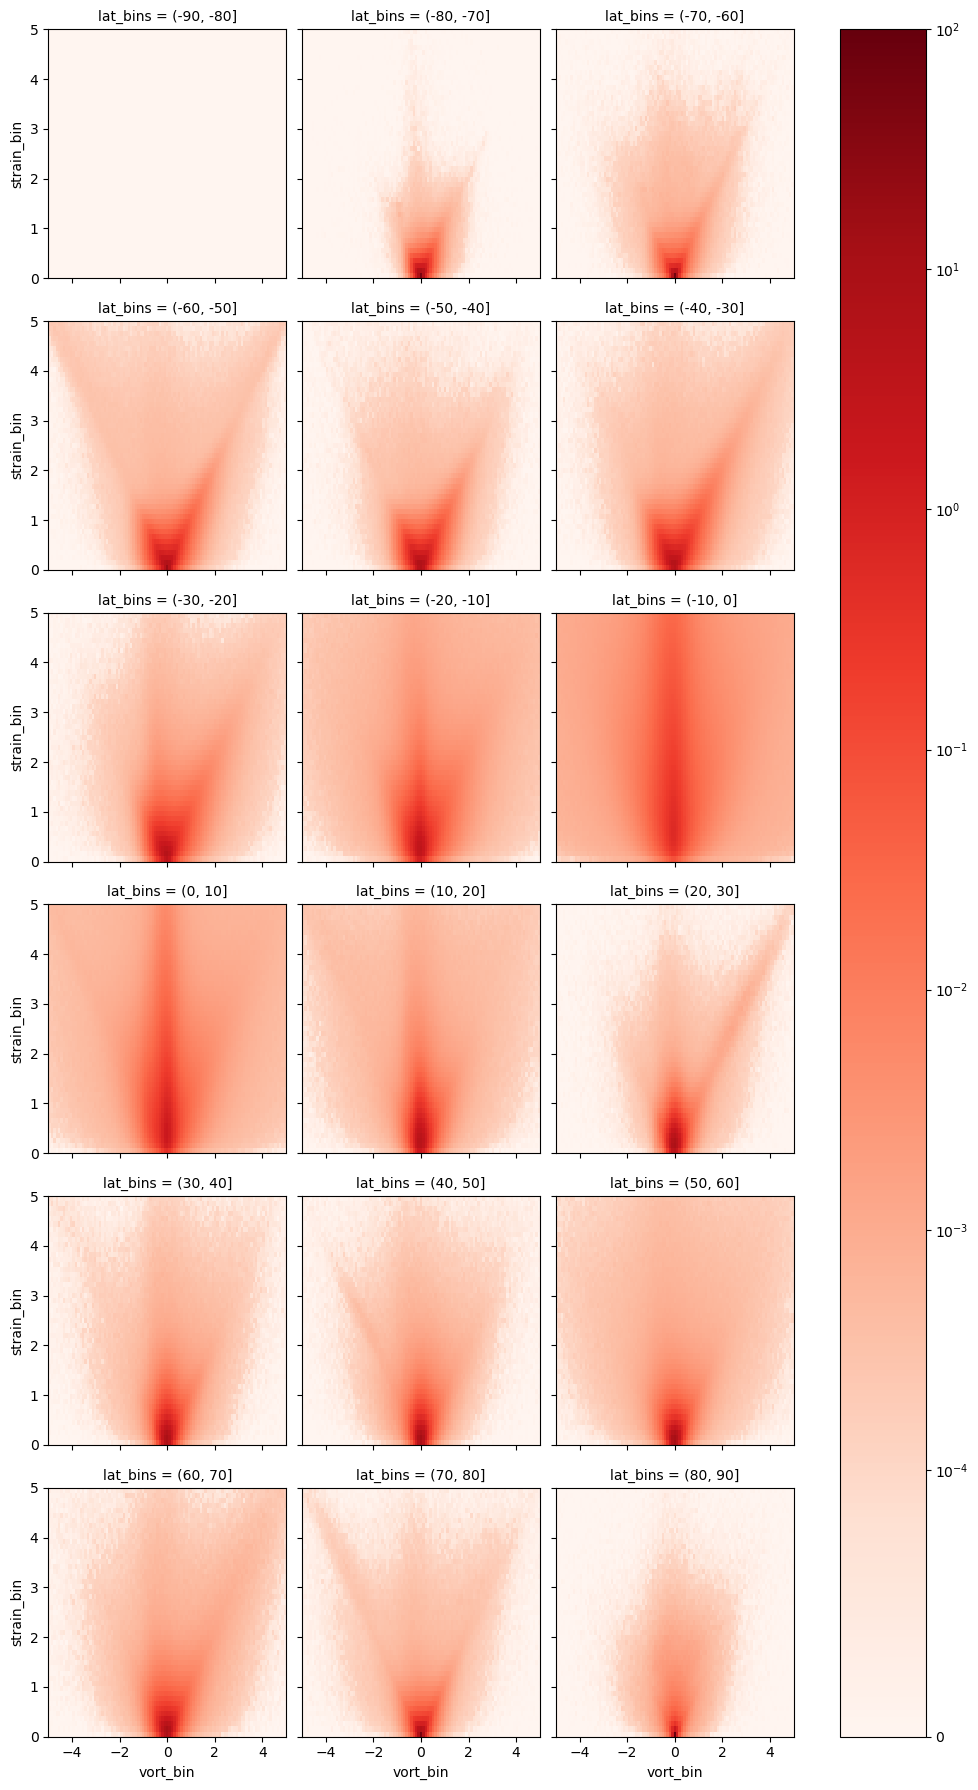

In [18]:
h_vort_strain_vs_lat.plot(x='vort_bin', col='lat_bins', col_wrap=3, vmax=1e2, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds')